<a href="https://colab.research.google.com/github/sganguly3000ai/makemore/blob/main/nanogpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bigram character level language model using neural network MLP Wavenet**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import string
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline


In [2]:
# the tiny-shakespeare.txt file is locally stored in the downloads/tiny-shakespeare.txt directory
# and should be uploaded to the sample_data directory in colab before running


# read it in to inspect it
with open('sample_data/tiny-shakespeare.txt', 'r', encoding='utf-8') as f:
  text = f.read()

names   = np.loadtxt('sample_data/tiny-shakespeare.txt', delimiter=' ', usecols = 0, dtype = str)
#lnames  = np.char.lower(names)
#words  = pd.unique(lnames)



In [3]:
print(f'Length of dataset in characters: {len(text)}')


Length of dataset in characters: 1115394


In [4]:
# lets look at the first 1000 characters
print (text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# CHARACTER LEVEL TOKENIZER
# create a mapping from characters to integers [look at sentence piece in google or tiktoken in openai]
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder : take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder : take a list of integers, output a string


In [7]:
# lets encode the entire text dataset and store it in a tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earlier will go to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [8]:
# Split the data into train and validation/dev
n = int(0.9*len(data)) # first 90% will be training data rest will be validation/dev
train_data = data[:n]
val_data = data[n:]

In [ ]:
# build the dataset
torch.manual_seed(1337)
batch_size = 4
block_size = 8 # context length: how many characters do we take to predict the next one?


def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x,y


xb, yb= get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('--------------')

for b in range(batch_size):
  for t in range(block_size):
    context = xb[b, :t+1]
    target  = yb[b, t]
    print(f'when input is {context.tolist()} the target is {target}')


In [114]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):

    #idx and targets are both (B, T) tensor of integers
    logits = self.token_embedding_table(idx) # B, T, C batch, time, channel

    if targets==None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):

    for _ in range(max_new_tokens):
      # get the predictions

      logits, loss = self(idx)

      # focus only on the last time step
      logits = logits[:,-1,:] # becomes (B, C)
      probs = F.softmax(logits, dim=-1) # (B, C)
      #sample for the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx


In [115]:
# instantiate model
m = BigramLanguageModel(vocab_size)
# create a Pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [116]:
batch_size = 32
for steps in range(10000):

  # sample a batch of data
  xb, yb = get_batch('train')

  # evaluate the loss
  logits, loss = m (xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.394822597503662


In [117]:
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=400)[0].tolist()))


Ke sonidin y y a!
Caril.n y, denjxhece w illd CHAL, mer thoun s's:Conchuntilalllevise sthat dy hangilyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht 


In [ ]:
# ---------------------------------------------------------------------------------------

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight   = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias     = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps        = eps
    self.momentum   = momentum
    self.training   = True
    # parameters trained with backprop
    self.gamma      = torch.ones(dim)
    self.beta       = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var  = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean         = x.mean(0, keepdim=True)                   # batch mean
      xvar          = x.var(0, keepdim=True, unbiased=True)     # batch variance
    else:
      xmean         = self.running_mean
      xvar          = self.running_var
    xhat            = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out        = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean   = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var    = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]
# ---------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out       = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
# ---------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn(num_embeddings, embedding_dim)

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
# ---------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self,n):
    self.n = n

  def __call__(self,x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []
# ---------------------------------------------------------------------------------------
class Sequential:   # container class
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and strech them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42); # seed rng (random number generator for reproducibility

In [ ]:
n_embd       = 24                                        # the dimensionality of the character embedding vectors
n_hidden    = 128                                 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])


with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))               # number of parameters in total
for p in parameters:
  p.requires_grad = True


76579


In [ ]:
n_embd       = 10                                         # the dimensionality of the character embedding vectors
n_hidden    = 200                                      # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(block_size), Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])


with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))               # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [ ]:
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  print(Xb.shape)
  print(logits.shape)

torch.Size([32, 8])
torch.Size([32, 27])


In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))
  # if layer.__class__.__name__ == 'FlattenConsecutive':
  #   print(layer.B, layer.T//layer.n,layer.C, layer.y, layer.sq,layer.z)

AttributeError: 'Embedding' object has no attribute 'out'

In [ ]:
# same optimization as last time

max_steps       = 200000
batch_size      = 32
lossi           = []

for i in range(max_steps):

  # minibatch construct (pluck bath_size samples out of the total number of samples randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)      # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 100000 else .01         # step learning rate decay
  for p in parameters:
    p.data   += -lr * p.grad

  # track stats
  if i % 10000 == 0:                      # print every 10000 iterations
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())




      0/ 200000: 3.291158
  10000/ 200000: 1.668053
  20000/ 200000: 2.133512
  30000/ 200000: 1.672420
  40000/ 200000: 1.829423
  50000/ 200000: 2.062600
  60000/ 200000: 1.834321
  70000/ 200000: 1.944229
  80000/ 200000: 1.711175
  90000/ 200000: 1.718177
 100000/ 200000: 1.524794
 110000/ 200000: 2.044667
 120000/ 200000: 2.109592
 130000/ 200000: 1.715780
 140000/ 200000: 1.465157
 150000/ 200000: 1.968511
 160000/ 200000: 1.837610
 170000/ 200000: 1.622568
 180000/ 200000: 1.605809
 190000/ 200000: 1.853185


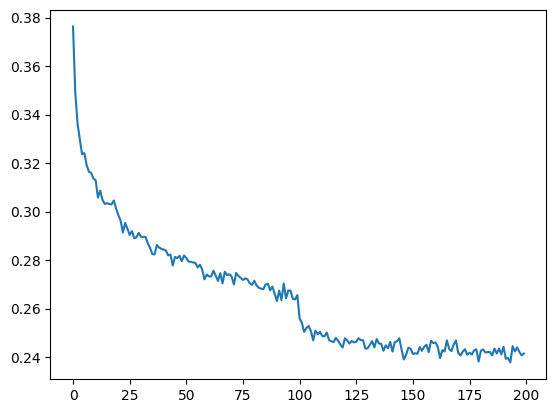

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# run to evaluate what the train and validation data is showing as per as the loss

@torch.no_grad()                                # this decorator disables gradient tracking
def split_loss(split):
  x,y = {'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
        }[split]

  # forward pass
  logits = model(x)
  # emb       = C[x]                          # embed the characters into vectors
  # x         = emb.view(emb.shape[0], -1)  # concatenate the vectors
  # for layer in layers:
  #   x = layer(x)
  #loss = F.cross_entropy(x, y)      # loss function
  loss = F.cross_entropy(logits, y)      # loss function

  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7109487056732178
val 1.9382123947143555


In [ ]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):

  out = []
  context = [0]*block_size # initialize with all '...'
  while True:

    logits = model(torch.tensor([context]))
    probs   = F.softmax(logits, dim=1)

    # sample from the distribution
    ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]

    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))


montay.
yazmine.
madyrian.
rener.
jendra.
gradeem.
selina.
mikoel.
edelina.
anastasy.
cortte.
cayshuberg.
hiran.
trinie.
jennique.
alfon.
marcel.
jamell.
eliyah.
javonny.
mahja.
salynn.
juazale.
veun.
natal.
kimea.
elinord.
jaqueshon.
gapeil.
shauntel.
